# Optimization of E. coli growth parameters for NUFEB
This notebook utilizes hyperparameter optimization to fit simulated E. coli growth curves to experimental data. Under the hood, we use scikit-optimize to perform a Bayesian optimization.

In [1]:
#Imports
import os
from random import uniform
import subprocess
from pathlib import Path
from nufeb_tools import utils,plot
import pandas as pd
import numpy as np

from skopt import gp_minimize
from skopt.plots import plot_convergence, plot_objective
import matplotlib.pyplot as plt
from scipy import interpolate
from sklearn.metrics import r2_score

# Optimization function
## Parameters to optimize:
### $\mu_{max}$ (Monod-based growth rate, $s^{-1}$)
### $\rho$ (Cell density, $\frac{kg}{m^3}$)
### $k_{sucrose}$ (Sucrose uptake half-maximum, $\frac{kg}{m^3}$)
### m (Cellular maintenance cost, $s^{-1}$)

In [2]:
def func(x):

    mu = x[0]
    rho = x[1]
    ksuc = x[2]
    maint = x[3]
    exp_x = np.array([ 0. ,  6.5, 10. , 12. , 14.5, 16.5, 18.5, 22.5, 26.5, 33. , 48. ,58. , 77. , 98. ])
    exp_y = np.array([0.003, 0.025, 0.11 , 0.245, 0.388, 0.44 , 0.504, 0.64 , 0.725, 0.788, 0.79 , 0.8  , 0.825, 0.83 ])

    #Clean old simulations
    os.chdir('/lustre/or-scratch/cades-cnms/12x')
    os.system('nufeb-clean')

    #Run simulation
    print(f'mu: {mu},rho: {rho}, ksuc: {ksuc}, m {maint}')
    text = f'nufeb-seed --cells 0,100 --grid 10 --t 17300 --suc 58.4 --muecw {mu}  --rhoecw {rho} --ksuc {ksuc} --maintecw {maint}'
    os.system(text)
    run_nufeb = subprocess.run('/home/12x/NUFEB/optim.sh', stdout=subprocess.DEVNULL)

    #Extract output
    BASE_DIR = Path(f'runs/')
    folders = [path for path in BASE_DIR.iterdir() if path.is_dir()]
    data = [utils.get_data(directory=str(x)) for x in folders]
    Volume = 1e-4*1e-4*1e-5 #m^3
    CellNum2OD = Volume/1e-9
    df = pd.concat([data[0].ntypes.ecw*CellNum2OD,data[0].ntypes.step/60/60*data[0].timestep],axis=1)
    df.columns=['OD600','Hours']


    #Compare output with experimental data
    exp = interpolate.interp1d(exp_x,exp_y)
    sim = interpolate.interp1d(df.Hours.to_numpy(),df.OD600.to_numpy())
    x_range = np.arange(0,48,.1)
    residual = abs(r2_score(exp(x_range),sim(x_range))-1)



    #print(residual)
    return residual
    #Optimize
"""    file_pi = open('results.obj', 'w') 
    pickle.dump(res, file_pi) """

"    file_pi = open('results.obj', 'w') \n    pickle.dump(res, file_pi) "

In [3]:
from tqdm.notebook import tqdm

class tqdm_skopt(object):
    def __init__(self, **kwargs):
        self._bar = tqdm(**kwargs)
        
    def __call__(self, res):
        self._bar.update()

In [4]:
mu_min = float('5.5e-5')
mu_max = float('1.1e-4')
rho_min = 185
rho_max = 307
k_suc_min = float('1e-1')
k_suc_max = float('1e1')
m_min = float('1e-8')
m_max = float('1e-7')
bounds = [(mu_min,mu_max),(rho_min,rho_max),(k_suc_min,k_suc_max),(m_min,m_max)]
n_calls = 100
gp_res = gp_minimize(func, bounds, n_calls=n_calls,random_state=5348,verbose=True,callback=[tqdm_skopt(total=n_calls, desc="Bayesian opt")])

Iteration No: 1 started. Evaluating function at random point.
mu: 7.029995126668965e-05,rho: 251, ksuc: 1.6262950783365364, m 3.835136980925619e-08
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 83.6512
Function value obtained: 426.6855
Current minimum: 426.6855
Iteration No: 2 started. Evaluating function at random point.
mu: 8.442183079433141e-05,rho: 244, ksuc: 0.832770406905429, m 2.1769051627819094e-08
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 970.5409
Function value obtained: 12812.2271
Current minimum: 426.6855
Iteration No: 3 started. Evaluating function at random point.
mu: 0.00010581367927452734,rho: 303, ksuc: 7.116610331420849, m 7.34962451615904e-08
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 33.0473
Function value obtained: 69.9936
Current minimum: 69.9936
Iteration No: 4 started. Evaluating function at random point.
mu: 6.676002087460051e-05,rho: 235, ksuc: 6.491959863022771, m 3.431339726249793e-08
I

Iteration No: 30 ended. Search finished for the next optimal point.
Time taken: 17.7367
Function value obtained: 2.3066
Current minimum: 0.5783
Iteration No: 31 started. Searching for the next optimal point.
mu: 5.5e-05,rho: 217, ksuc: 9.205118124078801, m 5.761737420869951e-08
Iteration No: 31 ended. Search finished for the next optimal point.
Time taken: 16.7742
Function value obtained: 0.9620
Current minimum: 0.5783
Iteration No: 32 started. Searching for the next optimal point.
mu: 5.5e-05,rho: 218, ksuc: 9.203909851293103, m 5.6932031035234284e-08
Iteration No: 32 ended. Search finished for the next optimal point.
Time taken: 16.4928
Function value obtained: 1.2729
Current minimum: 0.5783
Iteration No: 33 started. Searching for the next optimal point.
mu: 5.5e-05,rho: 307, ksuc: 6.508664515019714, m 9.72033363119874e-08
Iteration No: 33 ended. Search finished for the next optimal point.
Time taken: 17.3651
Function value obtained: 1.2595
Current minimum: 0.5783
Iteration No: 34 st

mu: 5.5e-05,rho: 185, ksuc: 6.857868921428705, m 1e-07
Iteration No: 61 ended. Search finished for the next optimal point.
Time taken: 18.0014
Function value obtained: 2.7757
Current minimum: 0.5783
Iteration No: 62 started. Searching for the next optimal point.
mu: 5.5e-05,rho: 253, ksuc: 9.202984433580962, m 9.733514766846056e-08
Iteration No: 62 ended. Search finished for the next optimal point.
Time taken: 16.9825
Function value obtained: 0.8954
Current minimum: 0.5783
Iteration No: 63 started. Searching for the next optimal point.
mu: 5.5e-05,rho: 185, ksuc: 6.784395047888928, m 1e-07
Iteration No: 63 ended. Search finished for the next optimal point.
Time taken: 15.9700
Function value obtained: 2.3593
Current minimum: 0.5783
Iteration No: 64 started. Searching for the next optimal point.
mu: 5.5e-05,rho: 307, ksuc: 9.233202098214548, m 1e-08
Iteration No: 64 ended. Search finished for the next optimal point.
Time taken: 14.2523
Function value obtained: 0.5725
Current minimum: 0.5

Iteration No: 90 ended. Search finished for the next optimal point.
Time taken: 14.5336
Function value obtained: 0.6223
Current minimum: 0.5582
Iteration No: 91 started. Searching for the next optimal point.
mu: 6.037671970424645e-05,rho: 282, ksuc: 9.999585435487877, m 1e-07
Iteration No: 91 ended. Search finished for the next optimal point.
Time taken: 14.1615
Function value obtained: 0.6180
Current minimum: 0.5582
Iteration No: 92 started. Searching for the next optimal point.
mu: 5.5e-05,rho: 307, ksuc: 9.810968565153171, m 9.163419562288142e-08
Iteration No: 92 ended. Search finished for the next optimal point.
Time taken: 13.3771
Function value obtained: 0.6272
Current minimum: 0.5582
Iteration No: 93 started. Searching for the next optimal point.
mu: 6.0456628395081784e-05,rho: 279, ksuc: 9.99949805503246, m 1e-07
Iteration No: 93 ended. Search finished for the next optimal point.
Time taken: 15.2722
Function value obtained: 0.9336
Current minimum: 0.5582
Iteration No: 94 starte

<AxesSubplot:title={'center':'Convergence plot'}, xlabel='Number of calls $n$', ylabel='$\\min f(x)$ after $n$ calls'>

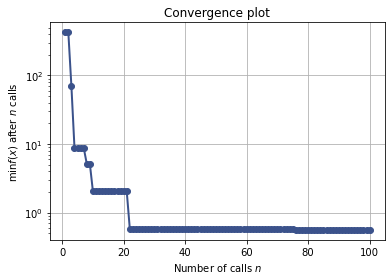

In [10]:
plot_convergence(gp_res,yscale='log')

array([[<AxesSubplot:xlabel='$X_{0}$', ylabel='Partial dependence'>,
        <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>],
       [<AxesSubplot:ylabel='$X_{1}$'>,
        <AxesSubplot:xlabel='$X_{1}$', ylabel='Partial dependence'>,
        <AxesSubplot:>, <AxesSubplot:>],
       [<AxesSubplot:ylabel='$X_{2}$'>, <AxesSubplot:>,
        <AxesSubplot:xlabel='$X_{2}$', ylabel='Partial dependence'>,
        <AxesSubplot:>],
       [<AxesSubplot:xlabel='$X_{0}$', ylabel='$X_{3}$'>,
        <AxesSubplot:xlabel='$X_{1}$'>, <AxesSubplot:xlabel='$X_{2}$'>,
        <AxesSubplot:xlabel='$X_{3}$', ylabel='Partial dependence'>]],
      dtype=object)

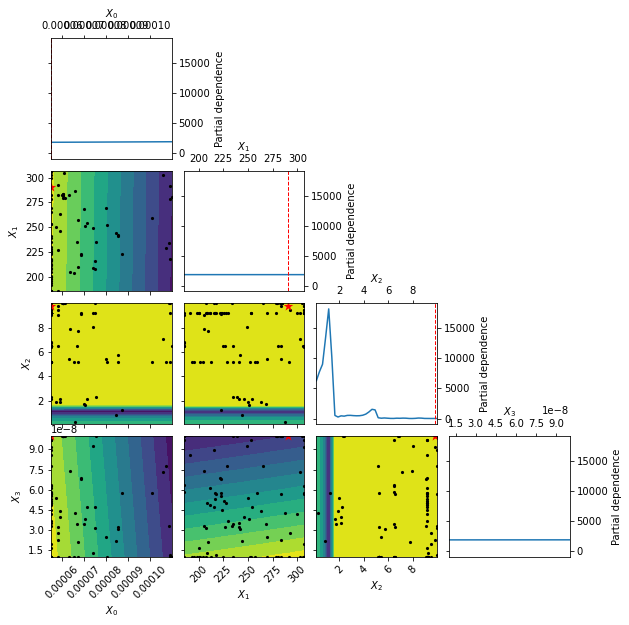

In [6]:
plot_objective(gp_res)

In [7]:
gp_res.x

[5.5e-05, 291, 9.818182532259979, 1e-07]

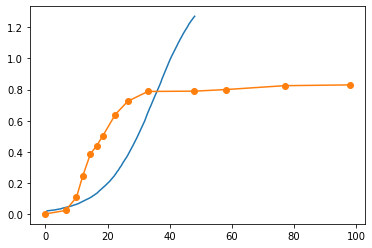

In [8]:
exp_x = np.array([ 0. ,  6.5, 10. , 12. , 14.5, 16.5, 18.5, 22.5, 26.5, 33. , 48. ,58. , 77. , 98. ])
exp_y = np.array([0.003, 0.025, 0.11 , 0.245, 0.388, 0.44 , 0.504, 0.64 , 0.725, 0.788, 0.79 , 0.8  , 0.825, 0.83 ])


os.chdir('/lustre/or-scratch/cades-cnms/12x')
os.system('nufeb-clean')

    #Run simulation

text = f'nufeb-seed --cells 0,100 --grid 10 --t 17300 --suc 58.4 --muecw {gp_res.x[0]}  --rhoecw {gp_res.x[1]} --ksuc {gp_res.x[2]} --maintecw {gp_res.x[3]}'
os.system(text)
run_nufeb = subprocess.run('/home/12x/NUFEB/optim.sh', stdout=subprocess.DEVNULL)
os.chdir('/lustre/or-scratch/cades-cnms/12x')
BASE_DIR = Path(f'runs/')
folders = [path for path in BASE_DIR.iterdir() if path.is_dir()]
data = [utils.get_data(directory=str(x)) for x in folders]
Volume = 1e-4*1e-4*1e-5 #m^3
CellNum2OD = Volume/1e-9
df = pd.concat([data[0].ntypes.ecw*CellNum2OD,data[0].ntypes.step/60/60*data[0].timestep],axis=1)
df.columns=['OD600','Hours']
f, ax = plt.subplots()
ax.plot(df.Hours,df.OD600,label='NUFEB')
ax.plot(exp_x,exp_y,marker='o',label='Experimental')
plt.show()